In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.metrics import mean_squared_error
import torch

import ConvexQNN
from LeastSquaresQNN import LSQNN
from LeastSquaresCQNN import LSCQNN

## Data Loading and Processing
Start by loading the data from the file. Then create the training and testing data sets based on the desired delay and train-test split ratio.

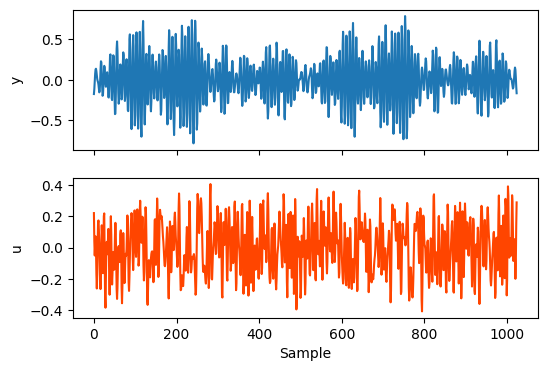

In [2]:
# Load data
data = np.genfromtxt("../Data/Robot-Arm/robot_arm.dat")
u = np.expand_dims(data[:,0], axis=1)
y = np.expand_dims(data[:,1], axis=1)

fig, axs = plt.subplots(2,1,figsize=(6,4),sharex=True)
axs[0].plot(y)
axs[0].set_ylabel("y")
axs[1].plot(u, color="orangered")
axs[1].set_ylabel("u")
axs[1].set_xlabel("Sample")
plt.show()

In [3]:
# Train/test split
training_split = 0.4
# Auto-regressive delay
delay = 6

# Split data
train_index = int(training_split*u.shape[0])
u_train = u[:train_index,:]
y_train = y[:train_index,:]
u_test  = u[train_index:,:]
y_test  = y[train_index:,:]

# Generate train data
dp_train = y_train.shape[0] - delay
X_train = np.zeros(shape=(dp_train, delay*2))
Y_train = np.zeros(shape=(dp_train, 1))
for i in range(dp_train):
    u_new = u_train[i:i+delay,[0]].T
    y_new = y_train[i:i+delay,[0]].T
    X_new = np.hstack([u_new, y_new])
    X_train[i,:] = X_new
    Y_train[i,0] = y_train[i+delay,0]
# Generate test data
dp_test = y_test.shape[0] - delay
X_test  = np.zeros(shape=(dp_test, delay*2))
Y_test  = np.zeros(shape=(dp_test, 1))
for i in range(dp_test):
    u_new = u_test[i:i+delay,[0]].T
    y_new = y_test[i:i+delay,[0]].T
    X_new = np.hstack([u_new, y_new])
    X_test[i,:] = X_new
    Y_test[i,0] = y_test[i+delay,0]

## Network Training
Train networks using the training set, then test in an auto-regressive manner on the testing set. The following networks are trained:
- Least squares trained CQNN
- Least squares trained QNN
- CVX training of QNN
- CVX training of CQNN
- Backpropagation training of CNN

In [4]:
"""LS-CQNN"""
f = 3
beta = 1e-10

# Train
lscqnn = LSCQNN()
tic = time.time()
lscqnn.Train(X_train, Y_train, f=f, beta=beta)
toc = time.time()
lscqnn_train_time = toc-tic

# Eval and print train time
print(f"Training Time:{lscqnn_train_time:.3f}s, Training Loss:{mean_squared_error(Y_train, lscqnn.Eval(X_train)):.2e}")

# Eval on train set
Y_pred_train_lscqnn = np.zeros_like(y_train)
for i in range(y_train.shape[0]):
    if i < delay:
        Y_pred_train_lscqnn[i,0] = y_train[i,0]
        continue
    x_u_ = u_train[i-delay:i,[0]].T
    x_y_ = Y_pred_train_lscqnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    Y_pred_train_lscqnn[i,0] = lscqnn.Eval(x_)[0,0]
Y_pred_train_lscqnn = Y_pred_train_lscqnn[delay:,:]

# Eval on test set
Y_pred_test_lscqnn = np.zeros_like(y_test)
for i in range(y_test.shape[0]):
    if i < delay:
        Y_pred_test_lscqnn[i,0] = y_test[i,0]
        continue
    x_u_ = u_test[i-delay:i,[0]].T
    x_y_ = Y_pred_test_lscqnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    Y_pred_test_lscqnn[i,0] = lscqnn.Eval(x_)[0,0]
Y_pred_test_lscqnn = Y_pred_test_lscqnn[delay:,:]

lscqnn_train_mse = mean_squared_error(Y_train, Y_pred_train_lscqnn)
lscqnn_test_mse  = mean_squared_error(Y_test, Y_pred_test_lscqnn)
print("Auto-regressive trials:")
print(f"Train Set MSE: {lscqnn_train_mse:.2e}, Test Set MSE: {lscqnn_test_mse:.2e}")

Training Time:0.018s, Training Loss:3.90e-07
Auto-regressive trials:
Train Set MSE: 6.88e-05, Test Set MSE: 1.90e-04


In [5]:
"""LS-QNN"""
beta = 1e-10

# Train
lsqnn = LSQNN()
tic = time.time()
lsqnn.Train(X_train, Y_train, beta=beta)
toc = time.time()
lsqnn_train_time = toc-tic
# Training loss and training time
print(f"Training Time:{lsqnn_train_time:.3f}s, Training Loss:{mean_squared_error(Y_train, lsqnn.Eval(X_train)):.2e}")

# Eval on train set
Y_pred_train_lsqnn = np.zeros_like(y_train)
for i in range(y_train.shape[0]):
    if i < delay:
        Y_pred_train_lsqnn[i,0] = y_train[i,0]
        continue
    x_u_ = u_train[i-delay:i,[0]].T
    x_y_ = Y_pred_train_lsqnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    Y_pred_train_lsqnn[i,0] = lsqnn.Eval(x_)[0,0]
Y_pred_train_lsqnn = Y_pred_train_lsqnn[delay:,:]

# Eval on test set
Y_pred_test_lsqnn = np.zeros_like(y_test)
for i in range(y_test.shape[0]):
    if i < delay:
        Y_pred_test_lsqnn[i,0] = y_test[i,0]
        continue
    x_u_ = u_test[i-delay:i,[0]].T
    x_y_ = Y_pred_test_lsqnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    Y_pred_test_lsqnn[i,0] = lsqnn.Eval(x_)[0,0]
Y_pred_test_lsqnn = Y_pred_test_lsqnn[delay:,:]

lsqnn_train_mse = mean_squared_error(Y_train, Y_pred_train_lsqnn)
lsqnn_test_mse  = mean_squared_error(Y_test, Y_pred_test_lsqnn)
print("Auto-regressive trials:")
print(f"Train Set MSE: {lsqnn_train_mse:.2e}, Test Set MSE: {lsqnn_test_mse:.2e}")

Training Time:0.032s, Training Loss:2.58e-07
Auto-regressive trials:
Train Set MSE: 5.78e-05, Test Set MSE: 2.40e-04


In [6]:
"""CVX QNN"""
# Train
tic = time.time()
Z_qnn, _, _ = ConvexQNN.QNN(X_train, Y_train, norm=2, beta=0, a=0.0937, b=0.5, c=0.4688)
toc = time.time()
cvxqnn_train_time = toc-tic

# Training loss and training time
cvxqnn_train_loss = mean_squared_error(Y_train, ConvexQNN.getResultsQNN(X_train, Z_qnn))
print(f"Training Time:{cvxqnn_train_time:.3f}s, Training Loss:{cvxqnn_train_loss:.2e}")

# Eval on train set
Y_pred_train_cvxqnn = np.zeros_like(y_train)
for i in range(y_train.shape[0]):
    if i < delay:
        Y_pred_train_cvxqnn[i,0] = y_train[i,0]
        continue
    x_u_ = u_train[i-delay:i,[0]].T
    x_y_ = Y_pred_train_cvxqnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    Y_pred_train_cvxqnn[i,0] = ConvexQNN.getResultsQNN(x_, Z_qnn)[0,0]
Y_pred_train_cvxqnn = Y_pred_train_cvxqnn[delay:,:]

# Eval on test set
Y_pred_test_cvxqnn = np.zeros_like(y_test)
for i in range(y_test.shape[0]):
    if i < delay:
        Y_pred_test_cvxqnn[i,0] = y_test[i,0]
        continue
    x_u_ = u_test[i-delay:i,[0]].T
    x_y_ = Y_pred_test_cvxqnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    Y_pred_test_cvxqnn[i,0] = ConvexQNN.getResultsQNN(x_, Z_qnn)[0,0]
Y_pred_test_cvxqnn = Y_pred_test_cvxqnn[delay:,:]

cvxqnn_train_mse = mean_squared_error(Y_train, Y_pred_train_cvxqnn)
cvxqnn_test_mse  = mean_squared_error(Y_test, Y_pred_test_cvxqnn)
print("Auto-regressive trials:")
print(f"Train Set MSE: {cvxqnn_train_mse:.2e}, Test Set MSE: {cvxqnn_test_mse:.2e}")

c:\Users\zacha\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
c:\Users\zacha\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


---Optimization Results---
Status: optimal
----------
Training Time:2.812s, Training Loss:2.57e-07
Auto-regressive trials:
Train Set MSE: 5.33e-05, Test Set MSE: 2.57e-04


In [7]:
"""CVX CQNN"""
f=3

# Train
tic = time.time()
Z_cqnn, _, _ = ConvexQNN.CQNN(X_train, Y_train, f=f, norm=2, beta=0, a=0.0937, b=0.5, c=0.4688)
toc = time.time()
cvxcqnn_train_time = toc-tic

# Training loss and training time
cvxcqnn_train_loss = mean_squared_error(Y_train, ConvexQNN.getResultsCQNN(X_train, Z_cqnn))
print(f"Training Time:{cvxcqnn_train_time:.3f}s, Training Loss:{cvxcqnn_train_loss:.2e}")

# Eval on train set
Y_pred_train_cvxcqnn = np.zeros_like(y_train)
for i in range(y_train.shape[0]):
    if i < delay:
        Y_pred_train_cvxcqnn[i,0] = y_train[i,0]
        continue
    x_u_ = u_train[i-delay:i,[0]].T
    x_y_ = Y_pred_train_cvxcqnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    Y_pred_train_cvxcqnn[i,0] = ConvexQNN.getResultsCQNN(x_, Z_cqnn)[0,0]
Y_pred_train_cvxcqnn = Y_pred_train_cvxcqnn[delay:,:]

# Eval on test set
Y_pred_test_cvxcqnn = np.zeros_like(y_test)
for i in range(y_test.shape[0]):
    if i < delay:
        Y_pred_test_cvxcqnn[i,0] = y_test[i,0]
        continue
    x_u_ = u_test[i-delay:i,[0]].T
    x_y_ = Y_pred_test_cvxcqnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    Y_pred_test_cvxcqnn[i,0] = ConvexQNN.getResultsCQNN(x_, Z_cqnn)[0,0]
Y_pred_test_cvxcqnn = Y_pred_test_cvxcqnn[delay:,:]

cvxcqnn_train_mse = mean_squared_error(Y_train, Y_pred_train_cvxcqnn)
cvxcqnn_test_mse  = mean_squared_error(Y_test, Y_pred_test_cvxcqnn)
print("Auto-regressive trials:")
print(f"Train Set MSE: {cvxcqnn_train_mse:.2e}, Test Set MSE: {cvxcqnn_test_mse:.2e}")

c:\Users\zacha\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
c:\Users\zacha\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


---Optimization Results---
Status: optimal
Final Z shape: (4, 4, 10)
----------
Training Time:16.963s, Training Loss:3.90e-07
Auto-regressive trials:
Train Set MSE: 6.89e-05, Test Set MSE: 1.91e-04


In [15]:
"""Backpropagation CNN"""
learning_rate = 0.01
weight_decay = 0
momentum = 0.9
num_epochs = 10000
torch.manual_seed(0)

_, channel_size = X_train.shape
_, output_size = Y_train.shape
filter_num = 128
filter_size = 3

class CNN_Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv1d(in_channels=1, out_channels=filter_num, kernel_size=filter_size, padding=0)
        out_size = int(filter_num*(channel_size - filter_size + 1))
        self.lin = torch.nn.Linear(in_features=out_size, out_features=output_size) 

    def forward(self, x):
        x = self.conv(x)
        x = torch.nn.functional.relu(x)
        x = torch.flatten(input=x, start_dim=1)
        x = self.lin(x)
        return x

CNN_model = CNN_Net()

X_train_tensor = torch.from_numpy(np.expand_dims(X_train, axis=1))
X_train_tensor = X_train_tensor.to(torch.float32)
Y_train_tensor = torch.from_numpy(Y_train)
Y_train_tensor = Y_train_tensor.to(torch.float32)

loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(CNN_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

epoch_print = int(num_epochs/10)
tic = time.time()
CNN_model.train()
for epoch in range(1, num_epochs+1):
    Y_pred = CNN_model(X_train_tensor)
    loss_value = loss(Y_pred, Y_train_tensor)

    CNN_model.zero_grad()
    loss_value.backward()
    optimizer.step()
    if (epoch == 1) or (epoch % epoch_print == 0):
        print(f"Epoch {epoch} training loss: {loss_value.item():.4f}")
CNN_model.eval()
toc = time.time()
bpcnn_time = toc-tic

# Evaluate
with torch.no_grad():
    # Train
    Y_pred_train_cnn = CNN_model(X_train_tensor)
    Y_pred_train_cnn = Y_pred_train_cnn.numpy()

bpcnn_train_loss = mean_squared_error(Y_train, Y_pred_train_cnn)
print(f"Time:{bpcnn_time:.3f}s, Training Loss:{bpcnn_train_loss:.2e}")

Y_pred_train_bpcnn = np.zeros_like(y_train)
for i in range(y_train.shape[0]):
    if i < delay:
        Y_pred_train_bpcnn[i,0] = y_train[i,0]
        continue
    x_u_ = u_train[i-delay:i,[0]].T
    x_y_ = Y_pred_train_bpcnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    with torch.no_grad():
        x_ = torch.from_numpy(np.expand_dims(x_, axis=1))
        x_ = x_.to(torch.float32)
        y_ = (CNN_model(x_).numpy())[0,0]
    Y_pred_train_bpcnn[i,0] = y_
Y_pred_train_bpcnn = Y_pred_train_bpcnn[delay:,:]

Y_pred_test_bpcnn = np.zeros_like(y_test)
for i in range(y_test.shape[0]):
    if i < delay:
        Y_pred_test_bpcnn[i,0] = y_test[i,0]
        continue
    x_u_ = u_test[i-delay:i,[0]].T
    x_y_ = Y_pred_test_bpcnn[i-delay:i,[0]].T
    x_ = np.hstack([x_u_, x_y_])
    with torch.no_grad():
        x_ = torch.from_numpy(np.expand_dims(x_, axis=1))
        x_ = x_.to(torch.float32)
        y_ = (CNN_model(x_).numpy())[0,0]
    Y_pred_test_bpcnn[i,0] = y_
Y_pred_test_bpcnn = Y_pred_test_bpcnn[delay:,:]

bpcnn_train_mse = mean_squared_error(Y_train, Y_pred_train_bpcnn)
bpcnn_test_mse  = mean_squared_error(Y_test, Y_pred_test_bpcnn)
print(f"Train MSE:{bpcnn_train_mse:.2e}, Test MSE:{bpcnn_test_mse:.2e}")

Epoch 1 training loss: 0.0877
Epoch 1000 training loss: 0.0005
Epoch 2000 training loss: 0.0002
Epoch 3000 training loss: 0.0001
Epoch 4000 training loss: 0.0001
Epoch 5000 training loss: 0.0001
Epoch 6000 training loss: 0.0000
Epoch 7000 training loss: 0.0000
Epoch 8000 training loss: 0.0000
Epoch 9000 training loss: 0.0000
Epoch 10000 training loss: 0.0000
Time:48.321s, Training Loss:2.83e-05
Train MSE:2.57e-03, Test MSE:3.22e-03


## Results
Plot results to compare the various networks

In [16]:
"""Plotting parameters"""
# What results to include
plot_lsqnn   = True
plot_lscqnn  = True
plot_cvxqnn  = True
plot_cvxcqnn = True
plot_bpcnn   = True

# Colors of each
color_truth   = "black"
color_lsqnn   = "forestgreen"
color_lscqnn  = "royalblue"
color_cvxqnn  = "purple"
color_cvxcqnn = "pink"
color_bpcnn   = "red"

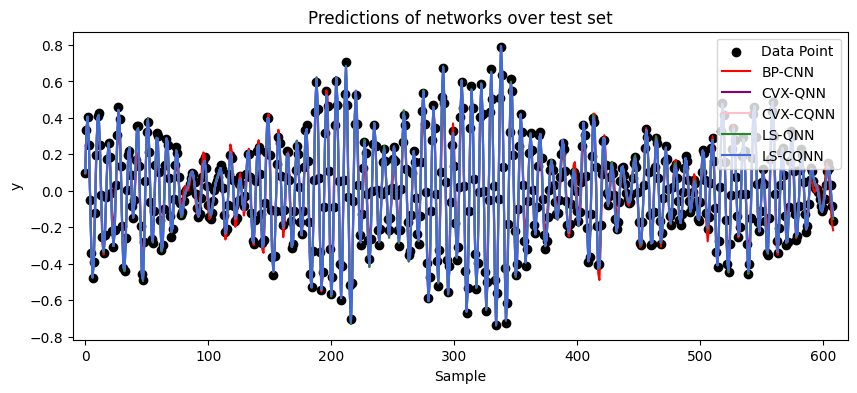

In [17]:
plt.figure(figsize=(10,4))
plt.title("Predictions of networks over test set")
t = np.linspace(0, Y_test.shape[0]-1, Y_test.shape[0])
plt.scatter(t, Y_test, color=color_truth, label="Data Point")
# plt.plot(t, Y_pred_test_bpcnn, color="red", label="BP-CNN")
if plot_bpcnn:
    plt.plot(t, Y_pred_test_bpcnn, color=color_bpcnn, label="BP-CNN")
if plot_cvxqnn:
    plt.plot(t, Y_pred_test_cvxqnn, color=color_cvxqnn, label="CVX-QNN")
if plot_cvxcqnn:
    plt.plot(t, Y_pred_test_cvxcqnn, color=color_cvxcqnn, label="CVX-CQNN")
if plot_lsqnn:
    plt.plot(t, Y_pred_test_lsqnn, color=color_lsqnn, label="LS-QNN")
if plot_lscqnn:
    plt.plot(t, Y_pred_test_lscqnn, color=color_lscqnn, label="LS-CQNN")
plt.legend(loc="best")
plt.xlim([-10,620])
plt.xlabel("Sample")
plt.ylabel("y")
plt.show()

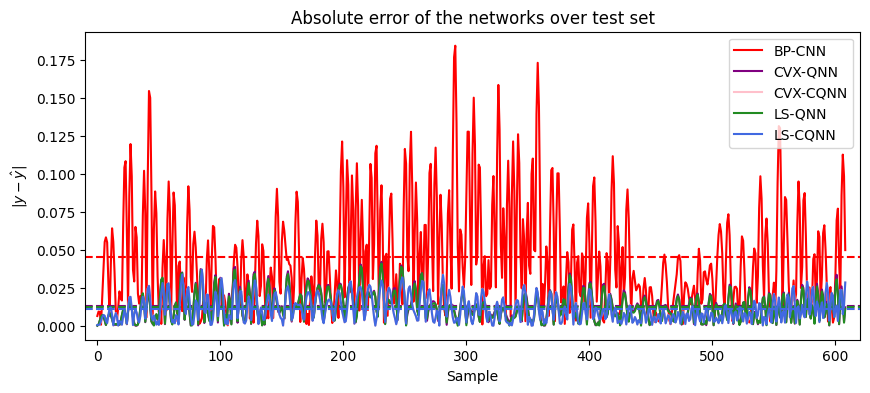

In [18]:
plt.figure(figsize=(10,4))
plt.title("Absolute error of the networks over test set")
t = np.linspace(0, Y_test.shape[0]-1, Y_test.shape[0])
if plot_bpcnn:
    plt.plot(t, np.abs(Y_pred_test_bpcnn-Y_test), color=color_bpcnn, label="BP-CNN")
    plt.axhline(np.mean(np.abs(Y_pred_test_bpcnn-Y_test)), ls="--", color=color_bpcnn)
if plot_cvxqnn:
    plt.plot(t, np.abs(Y_pred_test_cvxqnn-Y_test), color=color_cvxqnn, label="CVX-QNN")
    plt.axhline(np.mean(np.abs(Y_pred_test_cvxqnn-Y_test)), ls="--", color=color_cvxqnn)
if plot_cvxcqnn:
    plt.plot(t, np.abs(Y_pred_test_cvxcqnn-Y_test), color=color_cvxcqnn, label="CVX-CQNN")
    plt.axhline(np.mean(np.abs(Y_pred_test_cvxcqnn-Y_test)), ls="--", color=color_cvxcqnn)
if plot_lsqnn:
    plt.plot(t, np.abs(Y_pred_test_lsqnn-Y_test), color=color_lsqnn, label="LS-QNN")
    plt.axhline(np.mean(np.abs(Y_pred_test_lsqnn-Y_test)), ls="--", color=color_lsqnn)
if plot_lscqnn:
    plt.plot(t, np.abs(Y_pred_test_lscqnn-Y_test), color=color_lscqnn, label="LS-CQNN")
    plt.axhline(np.mean(np.abs(Y_pred_test_lscqnn-Y_test)), ls="--", color=color_lscqnn)
plt.legend(loc="best")
plt.xlim([-10,620])
plt.xlabel("Sample")
plt.ylabel(r"$|y-\hat{y}|$")
plt.show()

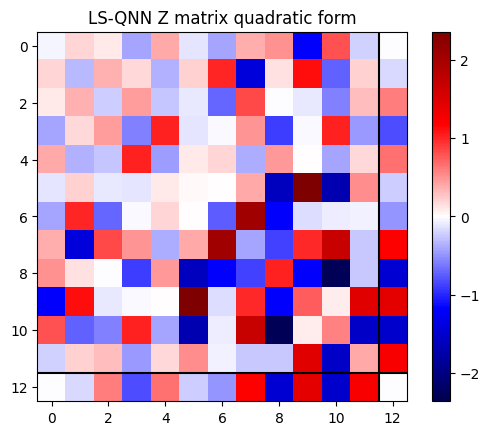

In [19]:
Z_lsqnn = lsqnn.Z_matrix(quadratic_params=True)
plt.title("LS-QNN Z matrix quadratic form")
plt.imshow(Z_lsqnn, cmap="seismic", vmin=-np.max(np.abs(Z_lsqnn)), vmax=np.max(np.abs(Z_lsqnn)))
plt.axhline(Z_lsqnn.shape[0]-1.5,color="black")
plt.axvline(Z_lsqnn.shape[0]-1.5,color="black")
plt.colorbar()
plt.show()

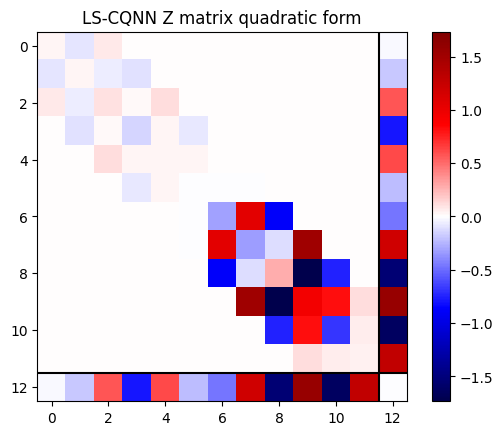

In [20]:
Z_lscqnn = lscqnn.Z_matrix(quadratic_params=True)
plt.title("LS-CQNN Z matrix quadratic form")
plt.imshow(Z_lscqnn, cmap="seismic", vmin=-np.max(np.abs(Z_lscqnn)), vmax=np.max(np.abs(Z_lscqnn)))
plt.axhline(Z_lscqnn.shape[0]-1.5,color="black")
plt.axvline(Z_lscqnn.shape[0]-1.5,color="black")
plt.colorbar()
plt.show()

In [21]:
u_0 = np.max(np.abs(u_train))*np.ones((6,1))
y_0 = np.max(np.abs(y_train))*np.ones((6,1))
x_0 = np.vstack((u_0, y_0))

a = lscqnn.a
b = lscqnn.b

dydx = 2*a*(Z_lscqnn[:-1,:-1] @ x_0) + b*Z_lscqnn[:-1,[-1]]
print(f"Maximum sensitivity of LS-CQNN over training set:\n {dydx}")

Maximum sensitivity of LS-CQNN over training set:
 [[-0.00506898]
 [-0.10941699]
 [ 0.30965828]
 [-0.41436743]
 [ 0.32899158]
 [-0.1190177 ]
 [-0.25722803]
 [ 0.90593699]
 [-1.24395708]
 [ 1.02902289]
 [-0.8998738 ]
 [ 0.67529917]]
